# Homework: Evaluation metrics

In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).

In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not.

## Data preparation
- Check if the missing values are presented in the features.
- If there are missing values:
    - For caterogiral features, replace them with 'NA'
    - For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with random_state=1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
# check if missing values are presented in the features
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [6]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [7]:
# replace missing values
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [8]:
from sklearn.model_selection import train_test_split

# split data into train/validation/test 
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [9]:
df_train.shape, df_val.shape, df_test.shape

((876, 9), (293, 9), (293, 9))

In [10]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [11]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [12]:
from sklearn.metrics import roc_auc_score

aucs = {}

for col in numerical:
    # Calculate AUC
    auc = roc_auc_score(y_train, df_train[col])
    
    # If AUC is < 0.5, invert the variable and recalculate
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
        print(f'AUC for -{col}: {auc:.4f}')
    else:
        print(f'AUC for {col}: {auc:.4f}')
        
    aucs[col] = auc

# Find the feature with the highest AUC
max_auc_feature = max(aucs, key=aucs.get)

print(f"The numerical variable with the highest AUC is: '{max_auc_feature}' with a score of {aucs[max_auc_feature]:.4f}")

AUC for number_of_courses_viewed: 0.7636
AUC for annual_income: 0.5520
AUC for interaction_count: 0.7383
AUC for lead_score: 0.6145
The numerical variable with the highest AUC is: 'number_of_courses_viewed' with a score of 0.7636


## Question 2: Training the model
Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)
- 0.32
- 0.52
- 0.72
- 0.92

In [13]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [14]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [17]:
auc = roc_auc_score(y_val, y_pred)

print(f"The AUC of the model on the validation dataset is: {auc:.3f}")

The AUC of the model on the validation dataset is: 0.919


## Question 3: Precision and Recall
Now let's compute precision and recall for our model.
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?
- 0.145
- 0.345
- 0.545
- 0.745

In [18]:
y_pred = model.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    # Manual calculation of TP, FP, FN
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    
    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (~predict_positive & actual_positive).sum()
    
    # Calculate precision and recall, handling division by zero
    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(p)
    recalls.append(r)

Intersection Point:
  Threshold: 0.5350
  Value: 0.8713


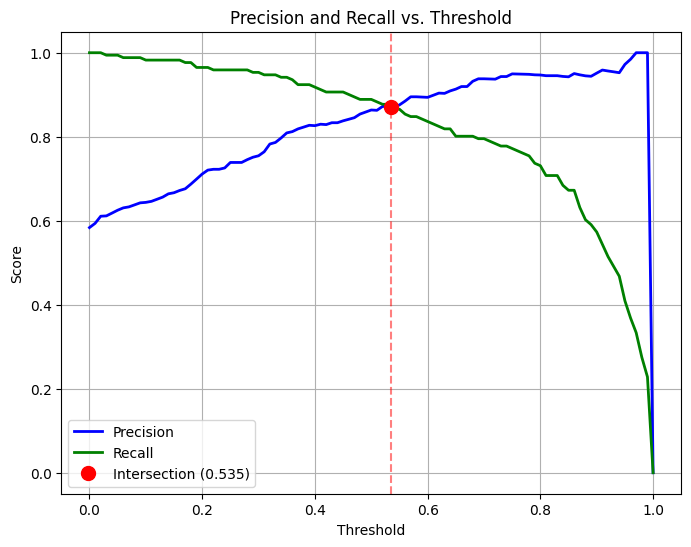

In [19]:
precisions = np.array(precisions)
recalls = np.array(recalls)
thresholds = np.array(thresholds)

# Find intersection point where precision crosses recall
# Look for sign change in (precision - recall)
diff = precisions - recalls
sign_change = np.where(np.diff(np.sign(diff)))[0]

if len(sign_change) > 0:
    # Use the first crossing point
    idx = sign_change[0]
    # Linear interpolation for more accurate intersection
    x1, x2 = thresholds[idx], thresholds[idx + 1]
    y1_p, y2_p = precisions[idx], precisions[idx + 1]
    y1_r, y2_r = recalls[idx], recalls[idx + 1]
    
    # Find exact intersection using linear interpolation
    intersection_threshold = x1 + (x2 - x1) * (y1_r - y1_p) / ((y2_p - y1_p) - (y2_r - y1_r))
    intersection_value = y1_p + (y2_p - y1_p) * (intersection_threshold - x1) / (x2 - x1)
else:
    # Fallback to minimum difference
    idx = np.argmin(np.abs(diff))
    intersection_threshold = thresholds[idx]
    intersection_value = precisions[idx]

print(f"Intersection Point:")
print(f"  Threshold: {intersection_threshold:.4f}")
print(f"  Value: {intersection_value:.4f}")

# Generate the plot with intersection point
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue', lw=2)
plt.plot(thresholds, recalls, label='Recall', color='green', lw=2)

# Mark the intersection
plt.plot(intersection_threshold, intersection_value, 'ro', 
         markersize=10, label=f'Intersection ({intersection_threshold:.3f})')
plt.axvline(x=intersection_threshold, color='red', linestyle='--', alpha=0.5)

plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Find the intersection point
intersection_idx = np.argmin(np.abs(np.array(precisions) - np.array(recalls)))
intersection_threshold = thresholds[intersection_idx]

print(f"The curves intersect at a threshold of approximately: {intersection_threshold:.3f}")

The curves intersect at a threshold of approximately: 1.000


## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

This is the formula for computing F1:

$$F_1 = 2 \cdot \frac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.14
* 0.34
* 0.54
* 0.74

In [21]:
# Evaluate F1 Score Across Thresholds
y_pred = model.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    # Get precision (P) and recall (R) for the current threshold
    actual_positive = (y_val == 1)
    predict_positive = (y_pred >= t)
    
    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & ~actual_positive).sum()
    fn = (~predict_positive & actual_positive).sum()
    
    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F1 score using the formula, handling division by zero
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1)

In [22]:
# Find and Print the Best Threshold
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]
max_f1_score = f1_scores[max_f1_index]

print(f"The maximum F1 score is {max_f1_score:.4f}, which occurs at a threshold of {best_threshold:.2f}")

The maximum F1 score is 0.8761, which occurs at a threshold of 0.50


## Question 5: 5-Fold CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```python
KFold(n_splits=5, shuffle=True, random_state=1)
```

- Iterate over different folds of `df_full_train`
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is the standard deviation of the scores across different folds?
- 0.0001
- 0.006
- 0.06
- 0.36

In [23]:
from sklearn.model_selection import KFold

# Initialize the KFold splitter
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

# Iterate over each fold
for train_idx, val_idx in kfold.split(df_train_full):
    # Split the data into training and validation sets for the current fold
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    # Get the target variables
    y_train = df_train.converted.values
    y_val = df_val.converted.values
    
    # Prepare feature dictionaries
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    val_dicts = df_val[categorical + numerical].to_dict(orient='records')

    # Apply one-hot encoding
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    # Train the logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Get predictions and calculate AUC
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

# Calculate and print the standard deviation
std_dev = np.std(scores)

print(f'Scores from each fold: {[round(s, 4) for s in scores]}')
print(f'Standard Deviation of scores: {std_dev:.4f}')

Scores from each fold: [0.8061, 0.8714, 0.7754, 0.8018, 0.8558]
Standard Deviation of scores: 0.0358


## Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C
- Iterate over the following `C` values: `[0.000001, 0.001, 1]`
- Initialize `KFold` with the same parameters as previously
- Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?
- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [24]:
# Initialize the KFold splitter
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# C values to test
c_values = [0.000001, 0.001, 1]

# Iterate over each C value to find the best one
for C in c_values:
    scores = []
    
    # Perform 5-fold cross-validation
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        train_dicts = df_train[categorical + numerical].to_dict(orient='records')
        val_dicts = df_val[categorical + numerical].to_dict(orient='records')
        
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)
        X_val = dv.transform(val_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    # Print the mean and standard deviation for the current C
    print(f"C = {C}:")
    print(f"  Mean AUC = {np.mean(scores):.3f}, STD = {np.std(scores):.3f}\n")

C = 1e-06:
  Mean AUC = 0.560, STD = 0.024

C = 0.001:
  Mean AUC = 0.867, STD = 0.029

C = 1:
  Mean AUC = 0.822, STD = 0.036

